## Learning diffusivity (m) to solution (u) map for Poisson problem (Implementation 2)

Data is located in `../data` directory, and key data of our interest is in `Poisson_samples.npz` file. We would also need the mesh data in files with names `Poisson_m_mesh` and `Poisson_u_mesh` for plotting.

### Results
Below shows the neural operator prediction for different samples of test input. 

<p align="center"> <img src="Results_implement2/neural_operator_prediction_comparison.png" width="800"> </p>

In [1]:
import sys
import os
import time

import torch
import numpy as np

util_path = "../../../utilities/"
sys.path.append(util_path)
from plotUtilities import field_plot_grid
from dataMethods import DataProcessorFNO
from torch_fno2d import FNO2D

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# set seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
data_folder = '../data/'
current_directory = os.getcwd()  
results_dir = current_directory + '/Results_implement2/'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

## Load data

In [6]:
num_train = 1900
num_test = 100

num_Y_components = 2 # displacement in 2D

coarsen_grid_factor = 3 # select every coarsen_grid_factor-th point so that we can coarsen the grid

# training hyperparameters
batch_size = 20
epochs = 400
lr = 1.0e-3

data_prefix = 'LinearElasticity'
data = DataProcessorFNO(data_folder + data_prefix + '_FNO_samples.npz', num_train, num_test, num_Y_components, coarsen_grid_factor)

train_data = {'X_train': data.X_train, 'Y_train': data.Y_train}
test_data = {'X_train': data.X_test, 'Y_train': data.Y_test}

print('X_train:',data.X_train.shape)
print('Y_train:',data.Y_train.shape)
print('X_test:',data.X_test.shape)
print('Y_test:',data.Y_test.shape)

X_train: torch.Size([1900, 41, 41, 3])
Y_train: torch.Size([1900, 41, 41, 2])
X_test: torch.Size([100, 41, 41, 3])
Y_test: torch.Size([100, 41, 41, 2])


## Create model and train the network

In [7]:
num_layers = 2
width = 20 # dimension of hidden output space
fourier_modes1 = 8
fourier_modes2 = 8

model = FNO2D(num_layers, width, fourier_modes1, fourier_modes2, num_Y_components)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters: {}'.format(trainable_params))

Number of trainable parameters: 103362


In [8]:
# Train
model.train(train_data, test_data, batch_size=batch_size, epochs = epochs, lr = lr)

Epoch:     0, Train Loss (l2 squared): 5.561e-01, Test Loss (l2 squared): 2.655e-01, Time (sec): 3.567
Epoch:   100, Train Loss (l2 squared): 2.982e-03, Test Loss (l2 squared): 2.462e-03, Time (sec): 6.855
Epoch:   200, Train Loss (l2 squared): 1.666e-03, Test Loss (l2 squared): 1.701e-03, Time (sec): 4.873
Epoch:   300, Train Loss (l2 squared): 1.388e-03, Test Loss (l2 squared): 1.222e-03, Time (sec): 4.806
Epoch:   399, Train Loss (l2 squared): 1.212e-03, Test Loss (l2 squared): 1.595e-03, Time (sec): 3.179


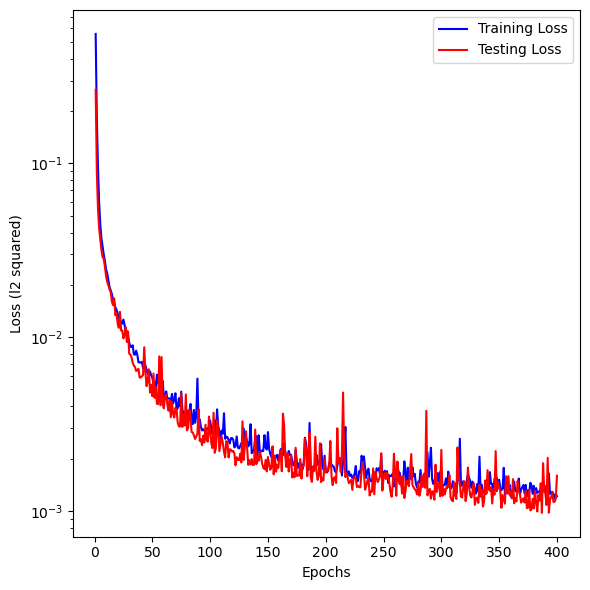

In [9]:
## Plotting the loss history
num_epoch = model.train_loss_log.shape[0]
x = np.linspace(1, num_epoch, num_epoch)
fig = plt.figure(constrained_layout=False, figsize=(6, 6))
gs = fig.add_gridspec(1, 1)
ax = fig.add_subplot(gs[0])
ax.plot(x, model.train_loss_log[:, 0], color='blue', label='Training Loss')
ax.plot(x, model.test_loss_log[:, 0], color='red', label='Testing Loss')
ax.set_yscale('log')
ax.set_ylabel('Loss (l2 squared)')
ax.set_xlabel('Epochs')
ax.legend(loc='best')
fig.tight_layout()
fig.savefig(results_dir+'loss_his.png',  bbox_inches='tight')
plt.show()

## Test and plot the output of network

In [10]:
Y_test = test_data['Y_train'].detach().numpy()
Y_test_pred = model.predict(test_data).detach().numpy()

print('test_out shape: {}, test_pred shape: {}'.format(Y_test.shape, Y_test_pred.shape))

a = Y_test.reshape(Y_test.shape[0], -1)
b = Y_test_pred.reshape(Y_test_pred.shape[0], -1)
print('a shape: {}, b shape: {}'.format(a.shape, b.shape))

error = np.linalg.norm(a - b, axis = 1)/np.linalg.norm(a, axis = 1)

print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(num_test, np.mean(error), np.std(error)))

test_out shape: (100, 41, 41, 2), test_pred shape: (100, 41, 41, 2)
a shape: (100, 3362), b shape: (100, 3362)
Num tests:   100, Mean Loss (rel l2): 7.029e-02, Std Loss (rel l2): 6.917e-02


In [11]:
i_plot = 0
i_pred = Y_test_pred[i_plot]
i_truth = Y_test[i_plot]
i_m_test = data.X_test[i_plot]
print('i_pred shape: {}, i_truth shape: {}, i_m_test shape: {}'.format(i_pred.shape, i_truth.shape, i_m_test.shape))

i_pred shape: (41, 41, 2), i_truth shape: (41, 41, 2), i_m_test shape: torch.Size([41, 41, 3])


i_plot =    26, error (rel l2): 1.084e-03
i_plot =    86, error (rel l2): 1.053e-03
i_plot =     2, error (rel l2): 1.379e-03
i_plot =    55, error (rel l2): 1.507e-03


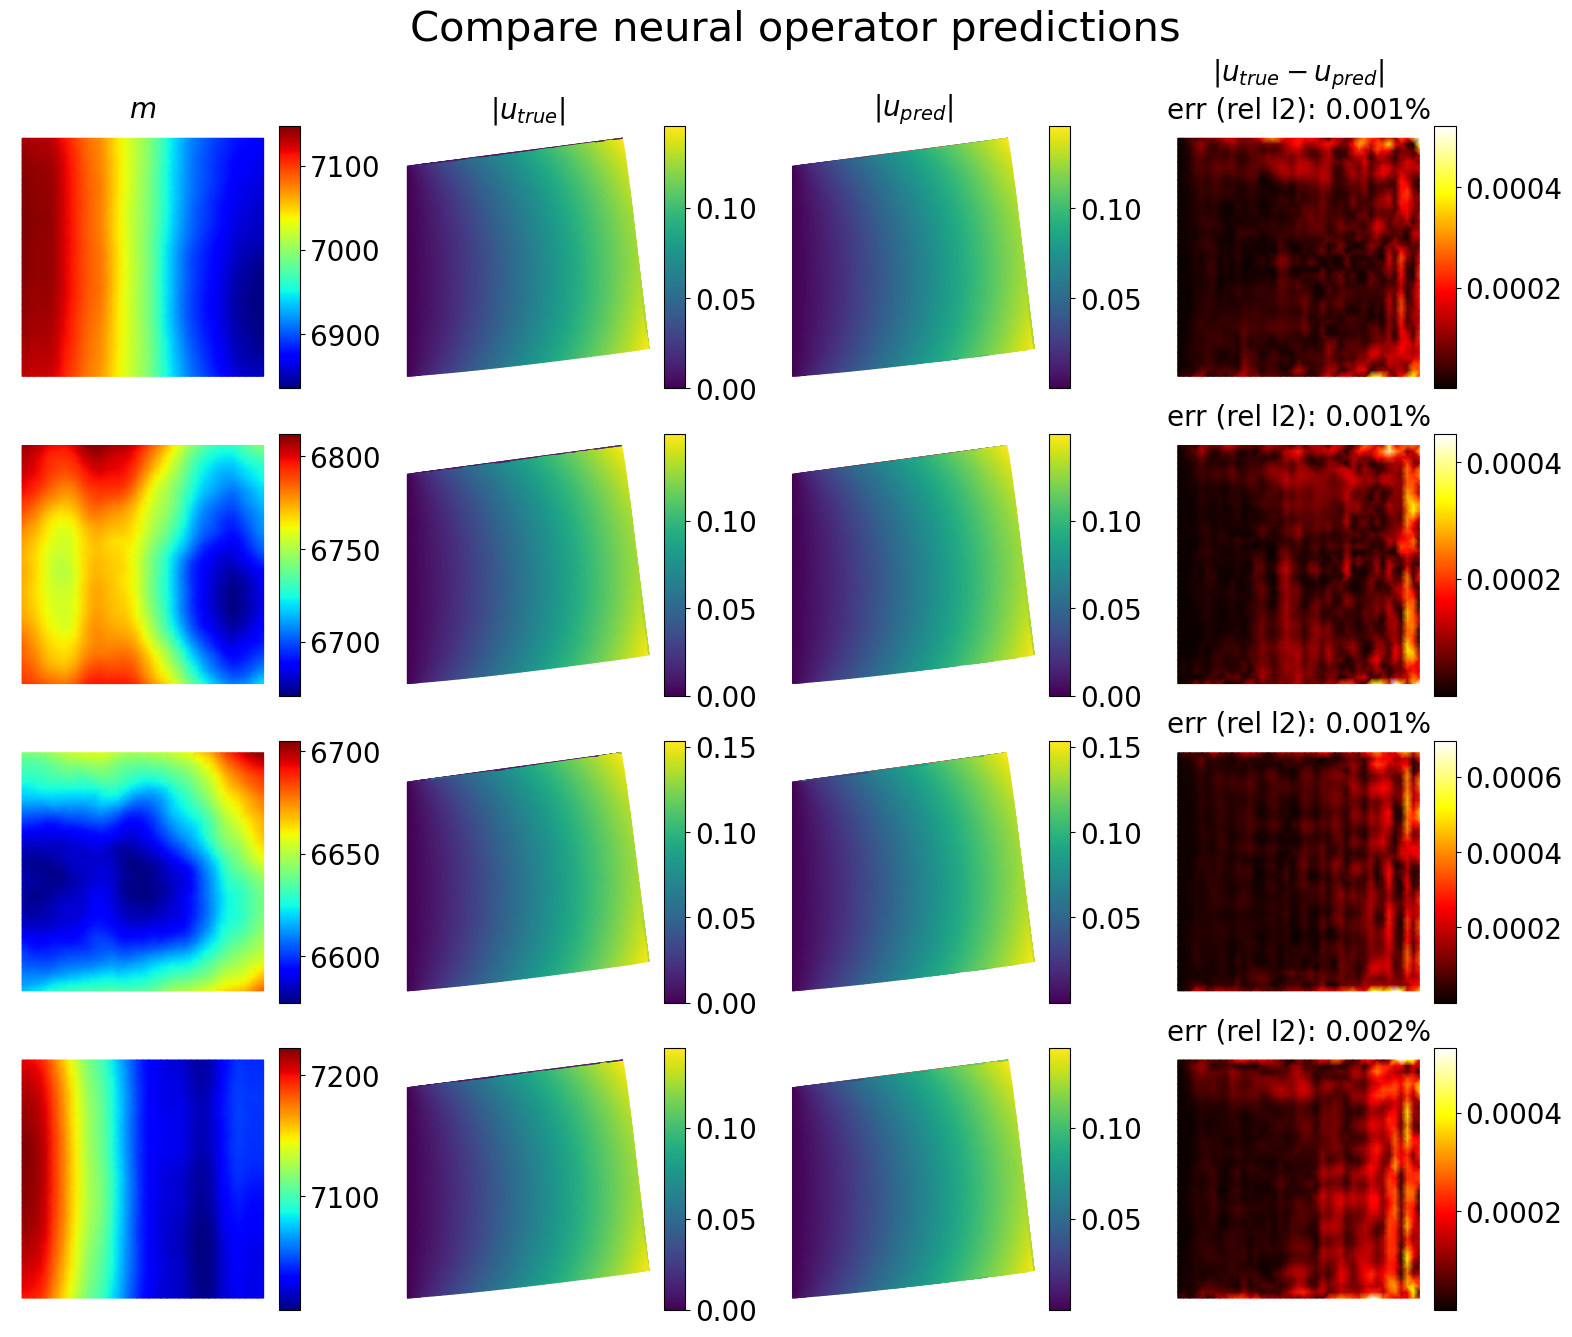

In [12]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 13))

decode = True

# row: m, u_true, u_pred, u_diff
u_tags = [r'$m$', r'$|u_{true}|$', r'$|u_{pred}|$', r'$|u_{true} - u_{pred}|$']
cmaps = ['jet', 'viridis', 'viridis', 'hot']

grid_x, grid_y = data.grid_x_test[0], data.grid_y_test[0]

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows, replace=False)

for i in range(rows):
    
    i_plot = i_choices[i]

    i_pred = Y_test_pred[i_plot][:, :, :]
    i_truth = Y_test[i_plot][:, :, :]
    i_m_test = data.X_test[i_plot][:, :, 0]
    if decode:
        i_pred = data.decoder_Y(i_pred)
        i_truth = data.decoder_Y(i_truth)
        i_m_test = data.decoder_X(i_m_test)
            
    i_diff = i_pred - i_truth
    i_diff_norm = np.linalg.norm(i_diff.flatten()) / np.linalg.norm(i_truth.flatten())
    print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

    uvec = [i_m_test, i_truth, i_pred, i_diff]
    
    for j in range(cols):

        if j == 0:
            cbar = field_plot_grid(axs[i,j], uvec[j], grid_x, grid_y, cmap = cmaps[j])
        elif j == cols - 1:
            cbar = field_plot_grid(axs[i, j],\
                        uvec[j], \
                        grid_x, \
                        grid_y, \
                        cmap = cmaps[j], \
                        add_displacement_to_nodes = False, \
                        is_displacement = True)
        else:
            cbar = field_plot_grid(axs[i, j],\
                        uvec[j], \
                        grid_x, \
                        grid_y, \
                        cmap = cmaps[j], \
                        add_displacement_to_nodes = True, \
                        is_displacement = True)

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)

        if j == 0 or j == cols - 1:
            # format cbar ticks
            kfmt = lambda x, pos: "{:g}".format(x)
            
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
        else:
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

        if i == 0 and j < cols - 1:
            axs[i,j].set_title(u_tags[j], fontsize=fs)
        
        if j == cols - 1:
            err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm)
            if i == 0:
                err_str = u_tags[j] + '\n' + err_str
            axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Compare neural operator predictions', fontsize=1.5*fs, y=1.025)
fig.savefig(results_dir+'neural_operator_prediction_comparison.png',  bbox_inches='tight')
plt.show()
